<a href="https://colab.research.google.com/github/ruturajkanake/lambdatest-assessment/blob/main/Non_Linear_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle 

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ruturajkanake/cityscapes-data

 95% 96.0M/101M [00:01<00:00, 41.6MB/s]
100% 101M/101M [00:01<00:00, 69.6MB/s] 


In [ ]:
! unzip cityscapes-data.zip

Archive:  cityscapes-data.zip
  inflating: cityscapes_data/train/1.jpg  
  inflating: cityscapes_data/train/10.jpg  
  inflating: cityscapes_data/train/100.jpg  
  inflating: cityscapes_data/train/1000.jpg  
  inflating: cityscapes_data/train/1001.jpg  
  inflating: cityscapes_data/train/1002.jpg  
  inflating: cityscapes_data/train/1003.jpg  
  inflating: cityscapes_data/train/1004.jpg  
  inflating: cityscapes_data/train/1005.jpg  
  inflating: cityscapes_data/train/1006.jpg  
  inflating: cityscapes_data/train/1007.jpg  
  inflating: cityscapes_data/train/1008.jpg  
  inflating: cityscapes_data/train/1009.jpg  
  inflating: cityscapes_data/train/101.jpg  
  inflating: cityscapes_data/train/1010.jpg  
  inflating: cityscapes_data/train/1011.jpg  
  inflating: cityscapes_data/train/1012.jpg  
  inflating: cityscapes_data/train/1013.jpg  
  inflating: cityscapes_data/train/1014.jpg  
  inflating: cityscapes_data/train/1015.jpg  
  inflating: cityscapes_data/train/1016.jpg  
  inflating

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torch

import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import transforms

In [ ]:
data_dir = os.path.join("cityscapes_data")

In [ ]:
train_dir = os.path.join(data_dir, "train") 

In [ ]:
val_dir = os.path.join(data_dir, "val")

In [ ]:
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print("train patch size:", len(train_fns))
print("validation patch size:", len(val_fns))

train patch size: 2975
validation patch size: 500


sample image shape:  (256, 512, 3)
image shape: (256, 256, 3)
label shape: (256, 256, 3)


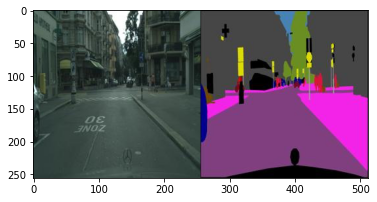

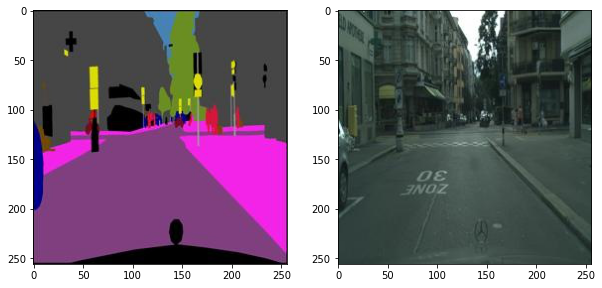

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)

def split_image(image):
    image = np.array(image)
    cityscape = image[:, :256, :] 
    label = image[:, 256:, :]
    return cityscape, label

sample_image = np.array(sample_image)
print("sample image shape: ",sample_image.shape)

cityscape, label = split_image(sample_image)
print("image shape:" , cityscape.shape)
print("label shape:" , label.shape)

cityscape = Image.fromarray(cityscape) 
label = Image.fromarray(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].imshow(cityscape)
axes[0].imshow(label)


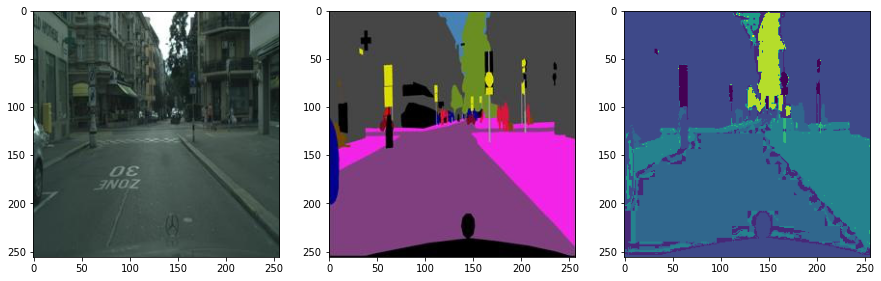

In [ ]:
num_items = 300
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)

num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

label_model.predict(color_array[:5, :])

cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [ ]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) 
        contracting_12_out = self.contracting_12(contracting_11_out) 
        contracting_21_out = self.contracting_21(contracting_12_out) 
        contracting_22_out = self.contracting_22(contracting_21_out) 
        contracting_31_out = self.contracting_31(contracting_22_out) 
        contracting_32_out = self.contracting_32(contracting_31_out) 
        contracting_41_out = self.contracting_41(contracting_32_out) 
        contracting_42_out = self.contracting_42(contracting_41_out) 
        middle_out = self.middle(contracting_42_out) 
        expansive_11_out = self.expansive_11(middle_out) 
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1))
        expansive_21_out = self.expansive_21(expansive_12_out) 
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1))
        expansive_31_out = self.expansive_31(expansive_22_out) 
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1))
        expansive_41_out = self.expansive_41(expansive_32_out) 
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) 
        output_out = self.output(expansive_42_out) 
        return output_out

In [ ]:
batch_size = 16
epochs = 5
lr = 0.001

In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

model = UNet(num_classes=num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

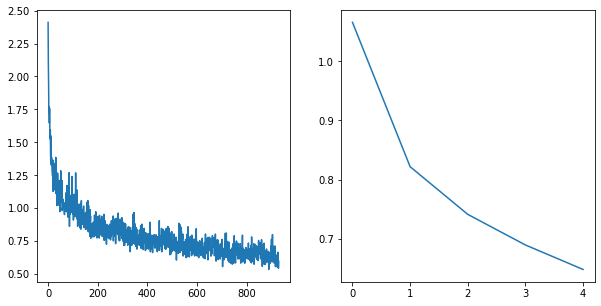

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "dimension_reduce.pth"
torch.save(model.state_dict(), model_name)
model_path = "dimension_reduce.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_batch_size = 5
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

torch.Size([5, 10, 256, 256])
torch.Size([5, 256, 256])


0.994954623421701


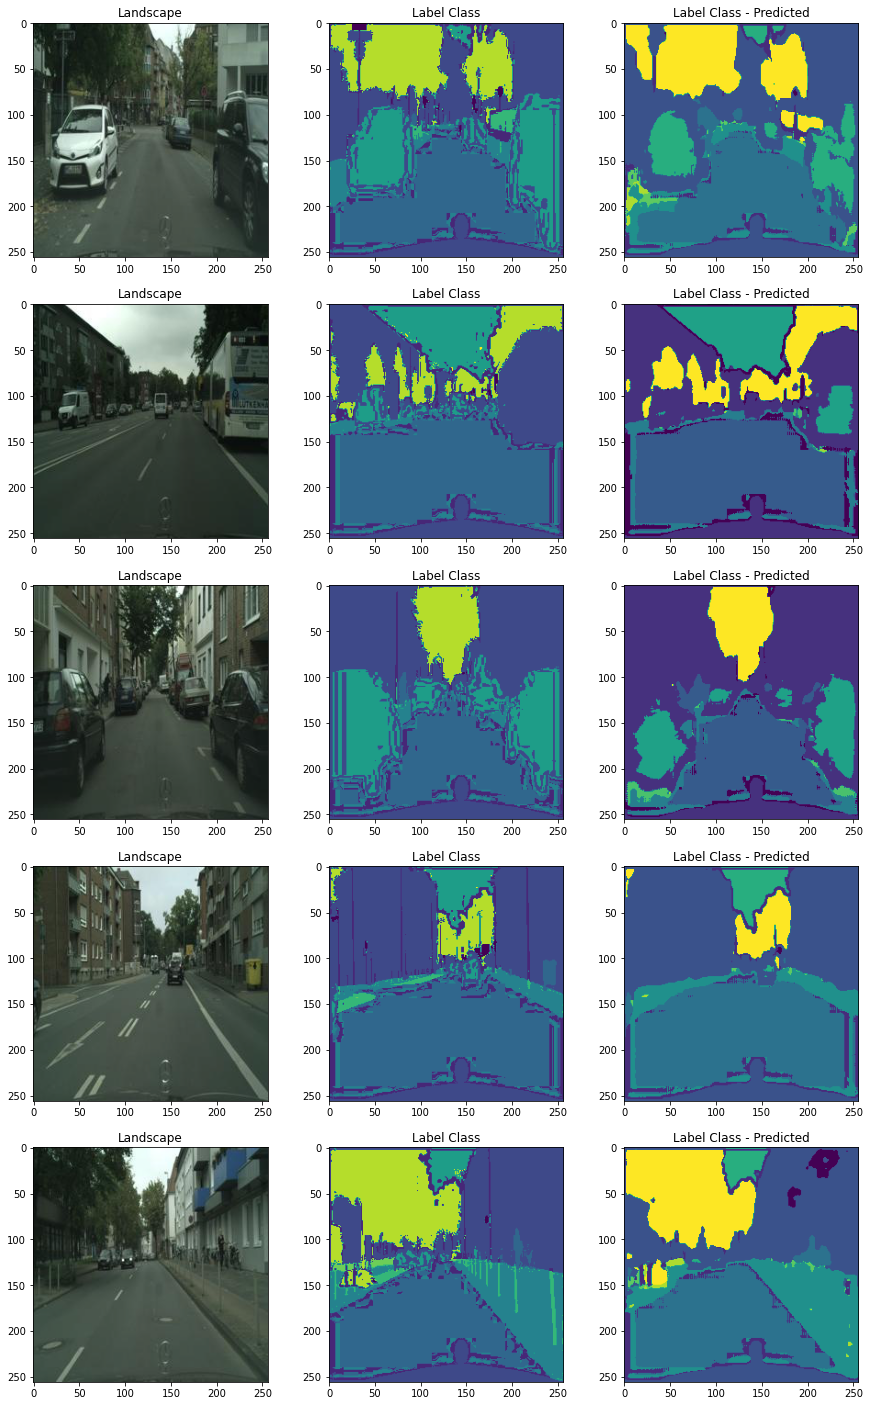

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

print(sum(iou_scores) / len(iou_scores))